In [1]:
import numpy as np
import pandas as pd
from sklearn import gaussian_process as gp
from matplotlib import dates, pyplot as plt
from sklearn.gaussian_process import kernels, GaussianProcessRegressor
from sklearn.preprocessing import normalize
from datetime import datetime
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa import arima_model

In [61]:
%matplotlib inline
plt.style.use('seaborn-talk')
np.set_printoptions(precision=4)

In [3]:
data = pd.read_hdf('../data/spy_2001_2013.1750.hdf', 'table')

In [4]:
truncated_data = data[np.abs(data) < 10 * np.std(data)].dropna()

In [5]:
def bipower(data):
    return np.sqrt(np.nansum(np.abs(data.iloc[1:] * data.iloc[:-1])))

In [6]:
real_vol = truncated_data.groupby(pd.TimeGrouper('D')).apply(bipower)
real_vol = real_vol[real_vol > 0]

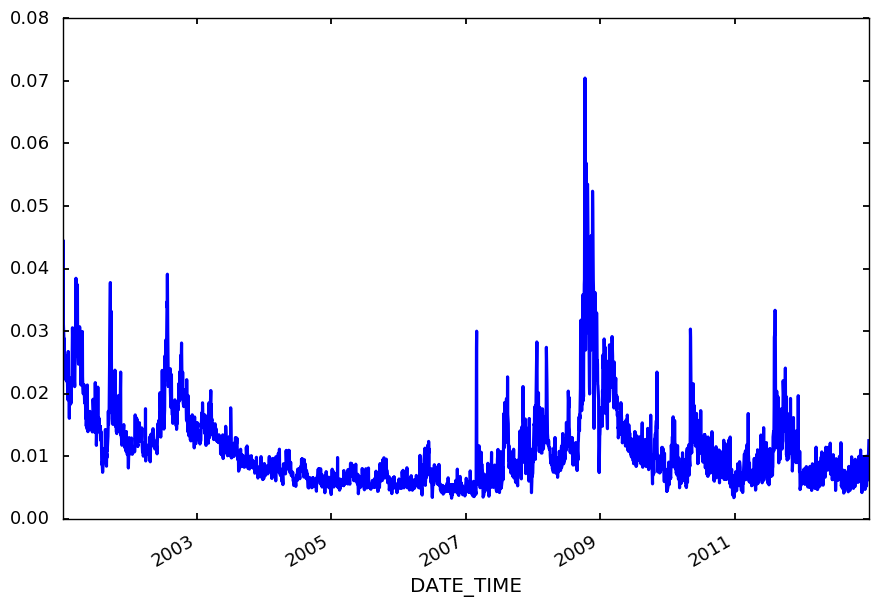

In [7]:
real_vol.plot()

In [8]:
def fit(data):
    xvals = normalize(((data.index.values - data.index.values.astype('datetime64[D]')) / 
                     np.timedelta64(1, 's')).reshape(-1,1))
    yvals = data.values.reshape(-1,1)
    model = GaussianProcessRegressor(kernel=kernel,normalize_y=True)
    model.fit(X=xvals, y=yvals)
    
    prediction = model.predict(xvals).ravel()
    return pd.Series(prediction, index=data.index)

In [9]:
grouped_data = truncated_data.groupby(pd.TimeGrouper('D'))

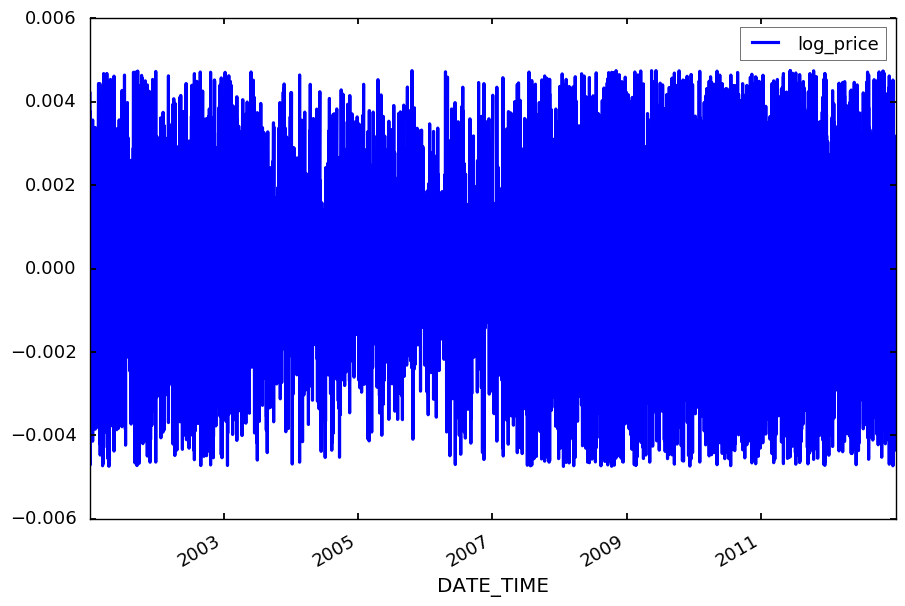

In [10]:
truncated_data.plot()

In [11]:
jumps = pd.concat([data[np.abs(data) > (3.5 * vol / np.sqrt(data.size))] for (name, data), vol  in 
           zip(truncated_data.groupby(pd.TimeGrouper('D')), real_vol) if data.size > 0]).dropna()
    

In [12]:
grouped_jumps = jumps.groupby(pd.TimeGrouper('D'))

In [13]:
jumps.columns

Index(['log_price'], dtype='object')

In [14]:
real_vol_pos_jumps = jumps.query('log_price > 0').groupby(pd.TimeGrouper('D')).apply(lambda x: np.sum(np.abs(x)))
real_vol_pos_jumps.columns = ['pos_jumps']

In [15]:
real_vol_neg_jumps = jumps.query('log_price < 0').groupby(pd.TimeGrouper('D')).apply(lambda x: np.sum(np.abs(x)))
real_vol_neg_jumps.columns = ['neg_jumps']

In [16]:
jumps_vol = pd.concat([real_vol_pos_jumps, real_vol_neg_jumps], axis=1)

In [17]:
np.corrcoef(jumps_vol['pos_jumps'], jumps_vol['neg_jumps'])

array([[ 1.  ,  0.99],
       [ 0.99,  1.  ]])

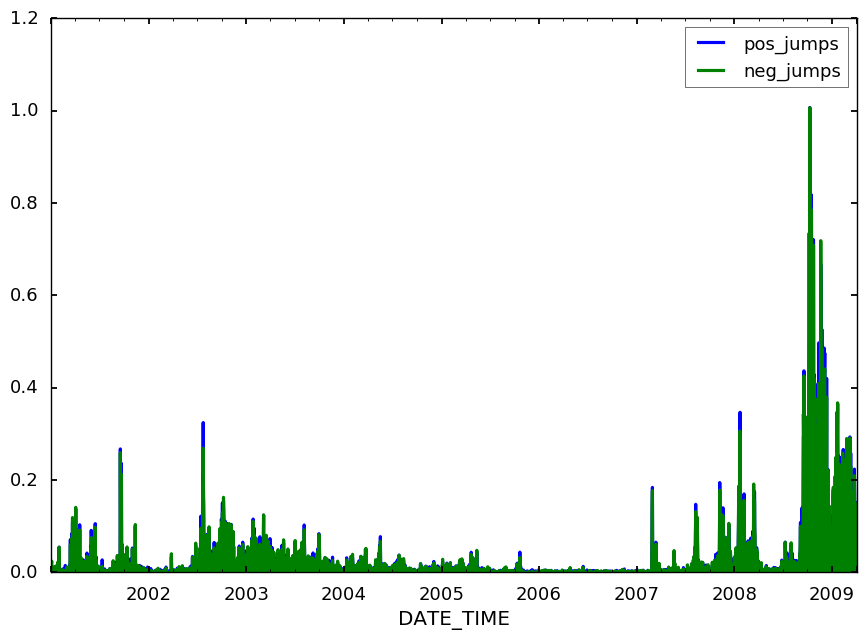

In [18]:
jumps_vol.plot()

In [19]:
kernel = kernels.Sum(kernels.WhiteKernel(noise_level=1e-8), kernels.Matern(nu=.51))

In [21]:
mean_jumps = pd.concat([pd.Series(fit(np.abs(group)).sum(), index=[name])
                        for name, group in grouped_jumps if len(group) > 0])

In [22]:
mean_jumps.head()

2001-01-02    0.013052
2001-01-03    0.036549
2001-01-04    0.007584
2001-01-05    0.010627
2001-01-08    0.012292
dtype: float64

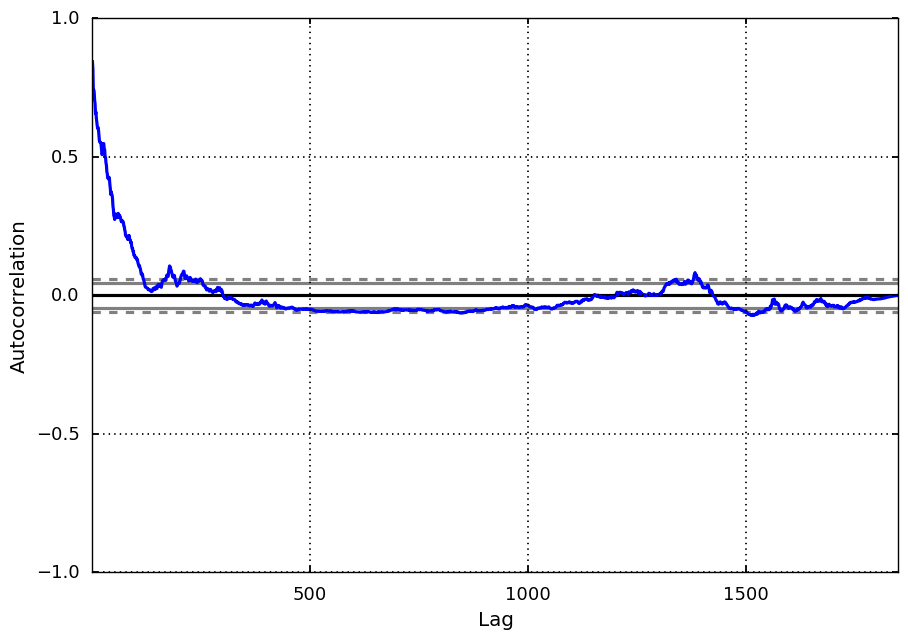

In [23]:
autocorrelation_plot(mean_jumps.values)

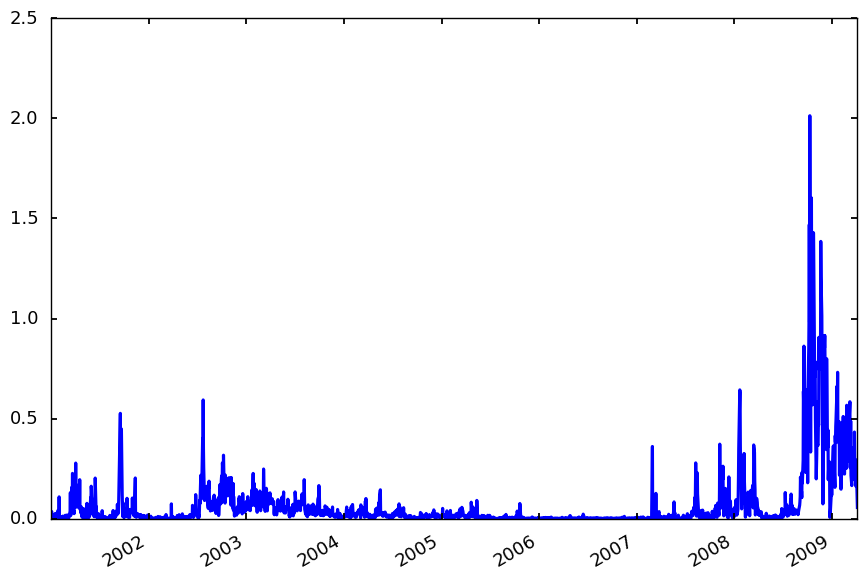

In [24]:
mean_jumps.plot()

In [64]:
results = arima_model.ARMA(mean_jumps.values, order=[20,0]).fit(np.zeros(21))
print(results.params)
print("\n")
print(np.sqrt(np.diag(results.cov_params())))

[  7.4982e-02   5.1911e-01   3.2659e-01  -2.1363e-01   1.2512e-01
   1.5222e-01  -5.8363e-02   4.8129e-02  -7.3163e-02   7.9196e-02
   1.5068e-02  -5.2650e-02   2.2380e-02  -5.2679e-03   4.4663e-02
   4.9009e-02  -6.9115e-02  -2.3848e-02   2.8232e-02  -3.3008e-04
   3.7022e-02]


[ 0.035   0.0233  0.0262  0.0273  0.0277  0.0278  0.028   0.0281  0.0281
  0.0282  0.0282  0.0283  0.0282  0.0282  0.0282  0.0282  0.028   0.0279
  0.0275  0.0264  0.0234]
